In [43]:
#
# Module permettant d'obtenir la matrice triangulaire recherchée pour un fichier audio 
# Mohammed-Bashir Mahdi - janvier 2019 - version V6-5
# Laurent Pottier - avril 2019 - version V6-7

# get_ipython().run_line_magic('matplotlib', 'inline')
import os
import sys
import math
import numpy as np
import scipy
import matplotlib.pyplot as plt
import librosa
import librosa.display
plt.rcParams['figure.figsize'] = (13, 5)


In [104]:
folder_path="/Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/Langages&Maths/Anaconda/LPanalyse/PopPlinn/class/PopPlinnTxtSel2"
#folder_path="/Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/Langages&Maths/Anaconda/LPanalyse/00_tests"

snd_folder_path="/Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/RechercheAnalyse/Corpus/"


filelist = []
for path, dirs, files in os.walk(folder_path):
    for filename in files:
        if 'txt' in filename :
                filelist.append(filename)
filelist.sort()

sndlist = []
sndpathlist = []
for path, dirs, files in os.walk(snd_folder_path, topdown=False):
#for path, dirs, files in os.walk(snd_folder_path, topdown=False):
    for filename in files:
        if 'wav' in filename :
                sndpathlist.append(path)
                sndlist.append(filename)
        if 'mp3' in filename :
                sndpathlist.append(path)
                sndlist.append(filename)
        if 'aiff' in filename :
                sndpathlist.append(path)
                sndlist.append(filename)

print("sndlist", len(sndlist))
print(len(filelist))
#print (filelist)

#get classes in string
class_path=os.chdir("/Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/Langages&Maths/Anaconda/LPanalyse/PopPlinn/class/PopPlinnTxtSel2/")
#class_path=os.chdir("/Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/Langages&Maths/Anaconda/LPanalyse/00_tests/")


sndlist 414
22


In [45]:
# read filetxt and generate array S
def read(filetext):
    with open(filetext) as f:
        mylist = f.read().splitlines()
        for x in range(8):
            mylist.pop(0)
        S=[]
        for element in reversed(mylist):
            element2=[float(i) for i in element.split()]
            S.append(element2)
        return S

In [69]:
file1 = filelist[1]
S1 = read(file1)
file2 = filelist[6]
S2 = read(file2)

print (file1)
print (file2)
# print (S1)

PopPlinn_sr44100_deb00_04_00_t02_00_pas02_00.txt
PopPlinn_sr44100_deb01_00_00_t02_00_pas02_00.txt


In [47]:

#--------------------------------------------#
# VARIABLES GLOBALES                         #
#--------------------------------------------#

# SR = 41000 Hz
# raies=[2, 3, 4, 5, 6, 8, 10, 13, 16, 20, 25, 32, 41, 51, 65, 81, 103, 129, 163, 206, 259, 327, 412, 519, 654, 824, 1038, 1307];
RAIES = [
    2, 3, 4, 5, 6, 8, 10, 13, 16, 20, 25, 32, 41, 51, 65, 81, 103, 129, 163,
    206, 259, 327, 412, 519, 654, 824, 1038, 1307
]

# Le nombre de moyennes différentes par fréquences
# Des basses fréquences jusqu'au hautes
NB_MOYENNE = [
    4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40,
    42, 44, 46, 48, 50, 52, 54, 56
]

SINUS_FREQ = [
    26.4, 37.3, 48.2, 59.0, 74.6, 96.3, 122.8, 155.3, 192.6, 240.7, 304.5,
    390.0, 492.3, 619.9, 781.2, 983.4, 1241.1, 1561.3, 1972.9, 2486.9, 3133.3,
    3951.9, 4978.6, 6272.7, 7903.7, 9957.3, 12540.5
]

# Taille de la fenêtre pour une FFT
T_FENETRE = 4096

# Le mode de lancement du programme
AS = "as"
ACF = "acf"
ACR = "acr"
H = "h"

# Les options possibles pour le programme
DEB = "deb"
T = "t"
PAS = "pas"
F = "f"
R = "r"
ROUT = "rout"  # répertoir de sorti

# La valeur par défaut des paramètres du programme
DEB_DEF = 0
T_DEF = 2000
T_MIN = 800
PAS_DEF = 3000

# Le nombre de fréquence différente obtenu
n_freq = 0


In [48]:

#--------------------------------------------#
# FONCTIONS USAGES                           #
#--------------------------------------------#


# Affiche l'aide concernant l'utilisation des paramètres (options)
def parametre_usage():
    print("\tPARAMÈTRES OBLIGATOIRES:", end="\n\n")
    print(
        "\t" + F +
        "=<fichier>\tchemin vers le fichier à analyser\n\t\t\tdisponible uniquement pour les modes "
        + AS + " et " + ACF + "\n\n" + "\t" + R +
        "=<répertoire>\tchemin vers le fichier à analyser\n\t\t\tdisponible uniquement pour le mode "
        + ACR,
        end="\n\n")
    print("\tPARAMÈTRES OPTIONNELS:", end="\n\n")
    print(
        "\t" + DEB +
        "=<entier>\tpoint de départ de l'analyse (en ms)\n\t\t\tvaleur par défaut : 0\n\n"
        + "\t" + T +
        "=<entier>\ttaille de l'analyse (en ms)\n\t\t\tvaleur par défaut : " +
        str(T_DEF) + "\n\t\t\tvaleur minimal : " + str(T_MIN) + "\n\n" + "\t" +
        PAS + "=<entier>\tpas d'avancement (en ms)\n\t\t\tvaleur par défaut : "
        + str(PAS_DEF) + "\n\t\t\tdisponible uniquement pour les modes " + ACF
        + " et " + ACR + "\n\n" + "\t" + ROUT +
        "=<rep>\trépertoire de sortie\n\t\t\tvaleur par défaut : .",
        end="\n\n")


# Affiche les différents modes d'analyse utilisable
def mode_analyse_usage():
    print(
        "\t" + AS + "\tanalyse simple\n" + "\t" + ACF +
        "\tanalyse complète d'un ficher audio\n" + "\t" + ACR +
        "\tanalyse complète d'un répertoire\n", )


# Affiche l'aide
def usage():
    print("AIDE :")
    print("\t" + sys.argv[0] + " <mode> <options>", end="\n\n")
    print("\tMODE:", end="\n\n")
    mode_analyse_usage()
    parametre_usage()
    exit()


# Affiche le message expliquant comment afficher l'aide
# Quitte le programme
def comment_aide():
    print("Pour afficher l'aide :\n\n" + "\t" + sys.argv[0] + " h", end="\n\n")
    exit()


In [49]:
mode_analyse_usage()

	as	analyse simple
	acf	analyse complète d'un ficher audio
	acr	analyse complète d'un répertoire



In [50]:
#--------------------------------------------#
# LES 'VRAIES' FONCTIONS                     #
#--------------------------------------------#
# Renvoie le nom du fichier en supprimant les 2 premier répertoires dans le chemin
def nom_fichier_entete(fichier):
    fin = 0
    i = 0
    nom = fichier
    while (fin < 2):
        if (fichier[i] == '/'):
            fin = fin + 1
        i = i + 1
    return nom[i:]


# Affiche la liste l passé en paramètre
def display_list(l):
    for i in range(0, len(l) - 1):
        print(str(i) + " || " + str(l[i]))


# Renvoie un np.array contenant le temps (pour l'utiliser avec plt.plot)
def time_list(sr, waveform):
    interval = 1 / sr
    temps = []
    for i in range(0, len(waveform), 1):
        temps.append(i * interval)
    return np.array(temps)


# Convertie un temps donnée en ms en un nombre de point selon la fréquence d'échantillonnage
# Les points correspondent à la représentation de la forme d'onde donnée par librosa.load
def time_to_point(temps, sr):
    points = temps * (sr / 1000)
    return int(round(points))


# La fonction réciproue de la fonction time_to_point
def point_to_time(nb_points, sr):
    return int(round((nb_points / sr) * 1000))


# Enregistre la forme d'onde graphique d'une ifft au format pdf
def ifft_forme_onde(ifft, sr, debut, dest, i):
    # Permet de savoir où nous en sommes dans le traitement
    temps = time_list(sr, ifft)
    plt.plot(temps, ifft)
    plt.xlabel("Temps")
    plt.ylabel("Amplitude")
    plt.title("Forme d'onde n°" + str(i))
    plt.savefig(dest + "freq" + str(debut) + "_" + str(i) + ".pdf")
    # Efface tous les tracés présents sur le graphe
    plt.gcf().clear()
    f = open(dest + "freq" + str(debut) + "_" + str(i) + ".txt", "w")
    for i in range(0, len(ifft), 1):
        f.write(str(ifft[i]) + "\n")
    f.close()


# Enregistre la forme d'onde audio d'une ifft au format pdf
def ifft_onde(ifft, sr, debut, dest, i):
    librosa.output.write_wav(dest + "freq" + str(debut) + "_" + str(i) + ".wav", ifft, sr)


# Affiche l'entête correspondant pour l'analyse simple
def affichage_entete_as(debut, taille, fichier, num_echantillon, sr):
    print("Fichier : " + nom_fichier_entete(fichier))
    print("Taux d'échantillonnage : " + str(sr) + " Hz")
    print("Echantillon : " + str(num_echantillon))
    print("début échantillon : " + str(point_to_time(debut, sr)) + " ms")
    print("taille échantillon : " + str(point_to_time(taille, sr)) + " ms")


# Renvoie une liste de taille n initilasé à la valeur val
def list_of_val(val, n):
    l = [val] * n
    return l


# Renvoie la somme des valeurs élevée au carré d'indice compris entre i_deb et i_fin inclus
def somme_carre_tab(tab, i_deb, i_fin):
    somme = 0
    i_fin = i_fin + 1
    for i in range(i_deb, i_fin, 1):
        somme = somme + (tab[i] * tab[i])
    return somme


def somme_tab(tab, i_deb, i_fin):
    somme = 0
    i_fin = i_fin + 1
    for i in range(i_deb, i_fin, 1):
        somme = somme + tab[i]
    return somme


# Renvoie la moyenne des valeurs d'indice compris entre i_deb et i_fin inclus
def moyenne_tab(tab, i_deb, i_fin):
    return somme_tab(tab, i_deb, i_fin) / (i_fin - i_deb + 1)


def moyenne_carre_tab(tab, i_deb, i_fin):
    return somme_carre_tab(tab, i_deb, i_fin) / (i_fin - i_deb + 1)


# Crée une matrice (format numpy array) de même taille que la fft passé en paramètre
# Toutes les valeurs sont null
def fft_null(fft):
    l_null = list_of_val((0 + 0j), len(fft[0]))
    fft_zero = []

    # Ajouter toutes les lignes à la matrice fft_zero
    i = 0
    while (i < len(fft)):
        fft_zero.append(l_null)
        i = i + 1

    # Conversion de la liste en array
    fft_zero = np.array(fft_zero)

    return fft_zero


# Changement des valeurs d'un array
# Copie le tableau de valeur 'tab_val' aux indices compris entre 'i_deb' et 'i_fin' (inclus) dans 'tab'
def change_valeur(i_deb, i_fin, tab_val, tab):
    for i in range(i_deb, (i_fin + 1), 1):
        tab[i] = np.copy(tab_val)
    return tab


# Prepare une ifft
# Prend la bande de 'raies' qui nous intéresse et la met dans 'fft_prep'
# La bande est comprise entre 'deb_bande' et 'fin_bande' (inclus)
def prepare_bande_ifft(fft_prep, fft, deb_bande, fin_bande):
    for i in range(deb_bande, fin_bande, 1):
        fft_prep[i] = np.copy(fft[i])
    return fft_prep


# Renvoie la fft inverse pour une raie donnée (la première raie est 0)
# zero_init est de type numpy array
def fft_to_ifft(fft_prep, fft, zero_init, raies, taille_waveform_original, i):
    i_deb_prec = 0

    if (i == 0):
        i_deb_prec = 1

    fft_prep = change_valeur(raies[i_deb_prec], raies[i], zero_init, fft_prep)
    fft_prep = prepare_bande_ifft(fft_prep, fft, raies[i], raies[i + 1])

    return librosa.istft(fft_prep, length=taille_waveform_original)


# Renvoie une échantillon de la 'waveform' compris entre debut et debut + taille (inclus)
# début et taille sont en point
def calculer_echantillon(waveform, debut, taille):
    echantillon = []
    fin = debut + taille
    for i in range(debut, fin, 1):
        echantillon.append(waveform[i])
    return np.array(echantillon)


# Crée l'entête du fichier comportant la matrice triangulaire
# Valeur de retour : l'entête du fichier
def entete_matrice_triangulaire(debut, taille, pas, fichier, sr, mode):
    entete = "#Fichier : " + nom_fichier_entete(fichier) + "\n"
    entete += "#Frequence d'echantillonnage : " + str(sr) + " Hz\n"
    entete += "#Debut : " + str(int(point_to_time(debut, sr))) + " ms\n"
    entete += "#Taille echantillon : " + str(int(point_to_time(taille, sr))) + " ms\n"
    entete += "#Taille fenetre : " + str(T_FENETRE) + "\n"
    entete += "#Nombre de frequences differentes : " + str(n_freq) + "\n"

    if (mode != AS):
        entete += "#Pas d'avancement : " + str(int(point_to_time(pas, sr))) + " ms"
    else:
        entete += "#"
                                            
    entete += "\n"
    return entete


# Renvoie une liste d'intervales pour une taille donnée
def liste_intervales(nb, taille):
    taille_intervale = int(taille / nb)
    intervals = [0] * nb

    for i in range(0, nb):
        intervals[i] = taille_intervale

    ecart = taille - nb * taille_intervale
    milieu = int(nb / 2)
    i = 0
    while (ecart > 0):
        intervals[milieu + i] = intervals[milieu + i] + 1
        if(i <= 0):
            i = -i + 1
        else:
            i = -i
        ecart -= 1

    return intervals


# Renvoie l'intensité de la couleur rouge en fonction de l'amplitude
# La conversion 20 * log(intensite) est faite à l'intérieur de la fonction
def red_amplitude(intensite):
    if intensite == 0:
        db = -96
    else:
        db = 20 * math.log(intensite, 10)
        if db < -96:
            db = -96

    if(db < -72):
        return 0
    elif (db <= -48):
        a = 1 / 24 # -48 - (-72) = 24
        b = a * 72
        return a * db + b
    elif (db < -24):
        return 1
    else:
        a = -1 / 24 # -24 - 0
        # Ici, b vaut 0, vf : graphe d'explication
        return  a * db


# Renvoie l'intensité de la couleur verte en fonction de l'amplitude
# La conversion 20 * log(intensite) est faite à l'intérieur de la fonction
def green_amplitude(intensite):
    if intensite == 0:
        db = -96
    else:
        db = 20 * math.log(intensite, 10)
        if db < -96:
            db = -96

    if (db < -48):
        return 1
    elif (db <= -24):
        a = 1 / -24 # En fait, l'écart entre 2 est toujours de -24
        b = a * 24 # a * -24 + b = 0
        return a * db + b
    else:
        return 0


# Renvoie l'intensité de la couleur bleu en fonction de l'amplitude
# La conversion 20 * log(intensite) est faite à l'intérieur de la fonction
def blue_amplitude(intensite):
    if intensite == 0:
        db = -96
    else:
        db = 20 * math.log(intensite, 10)
        if db < -96:
            db = -96

    if db <= -72:
        a = -1 / 24
        b = a * 72
        return a * db + b
    elif db < -24:
        return 0
    else:
        a = 1 / 24
        b = 1
        return a * db + b


# Crée et renvoie une ligne composat la matrice du graphe des températures
def ligne_graphe_temperature(ligne, taille, coef, i):
    nb_interval = len(ligne)
    intervales = liste_intervales(nb_interval, taille * coef)

    i = 0
    l = []
    while i < nb_interval:
        for j in range(0, intervales[i], 1):
            r = red_amplitude(ligne[i])
            v = green_amplitude(ligne[i])
            b = blue_amplitude(ligne[i])
            l.append((r, v, b))
        i += 1
    return l


In [51]:

# crée et enregiste le graphe des températures pour une matrice triangulaire donnée
def graphe_temperature(matrice_triangulaire, debut, taille, pas, fichier, sr, rout, mode):
    # Mise en place de la destination de sauvegarde
    fichier_dest = fichier.split("/")
    fichier_dest = fichier_dest[len(fichier_dest) - 1]
    if mode == AS:
        val_pas = ""
    else:
        val_pas = "_pas" + strpointtotime2(pas, sr)
    #dest = rout + fichier_dest + "_sr" + str(sr) + "_deb" + str(point_to_time(debut, sr)) + "_t" + str(point_to_time(taille, sr)) + val_pas + ".pdf"
    dest = rout + fichier_dest + "_sr" + str(sr) + "_deb" + strpointtotime(debut, sr) + "_t" + strpointtotime2(taille, sr) + val_pas + ".pdf"

    M = []

    for i in range(0, len(matrice_triangulaire), 1):
        l = ligne_graphe_temperature(matrice_triangulaire[i], len(matrice_triangulaire), 10, i)
        j = 0
        while j < 10:
            M.append(l)
            j += 1

    plt.xticks([])
    # plt.yticks([0, 4 * 10, int(len(matrice_triangulaire)/2) * 10, (len(matrice_triangulaire) - 1) * 10],
    #            [SINUS_FREQ[len(SINUS_FREQ) - 1], SINUS_FREQ[22], SINUS_FREQ[int(len(SINUS_FREQ) / 2)], SINUS_FREQ[0]])
    plt.yticks([5, 5 + 4 * 10, 5 + int(len(matrice_triangulaire)/2) * 10, 5 + (len(matrice_triangulaire) - 1) * 10],
                [SINUS_FREQ[len(SINUS_FREQ) - 1], SINUS_FREQ[22], SINUS_FREQ[int(len(SINUS_FREQ) / 2)], SINUS_FREQ[0]])
    plt.imshow(M)
    plt.savefig(dest)

# crée et enregiste le graphe des températures triée pour une matrice triangulaire donnée
def graphe_temperature2(matrice_triangulaire, debut, taille, pas, fichier, sr, rout, mode):
    # Mise en place de la destination de sauvegarde
    fichier_dest = fichier.split("/")
    fichier_dest = fichier_dest[len(fichier_dest) - 1]
    if mode == AS:
        val_pas = ""
    else:
        val_pas = "_pas" + strpointtotime2(pas, sr)
    #dest = rout + fichier_dest + "_sr" + str(sr) + "_deb" + str(point_to_time(debut, sr)) + "_t" + str(point_to_time(taille, sr)) + val_pas + ".pdf"
    dest = rout + fichier_dest + "_sr" + str(sr) + "_deb" + strpointtotime(debut, sr) + "_t" + strpointtotime2(taille, sr) + val_pas + "_tri.pdf"
    
    M = []
    lenMatTri = len(matrice_triangulaire)
 
    for i in range(0, lenMatTri, 1):
        line = matrice_triangulaire[i]
        line.sort(reverse=True)
        l = ligne_graphe_temperature(line, lenMatTri, 10, i)
        j = 0
        while j < 10:
            M.append(l)
            j += 1

    plt.xticks([])
    plt.yticks([5, 5 + 4 * 10, 5 + int(lenMatTri/2) * 10, 5 + (lenMatTri - 1) * 10],
                [SINUS_FREQ[len(SINUS_FREQ) - 1], SINUS_FREQ[22], SINUS_FREQ[int(len(SINUS_FREQ) / 2)], SINUS_FREQ[0]])
    plt.imshow(M)
    plt.savefig(dest)
    
    
# Renvoie une liste de moyenne
# Decompose le tableau 'tab' en une liste de 'nb_moyenne' case
# Chaque moyenne est passé à la racine
# Chaque case correspond à une moyenne
def decompose_moyenne_racine(nb_moyenne, tab):
    i = 0
    increment = int(len(tab) / nb_moyenne)
    i_deb = 0
    i_fin = increment
    moy = []
    while (i < nb_moyenne):
        moy.append(math.sqrt((moyenne_carre_tab(tab, i_deb, i_fin - 1))))
        i_deb = i_fin
        i_fin = i_fin + increment
        i = i + 1
    return np.array(moy)


def decompose_moyenne(nb_moyenne, tab):
    i = 1
    tab_tmp = np.copy(tab)
    increment = int(len(tab) / nb_moyenne)
    i_deb = 0
    i_fin = increment
    split_position = []
    while (i < nb_moyenne):
        i_deb = i_fin
        i_fin = i_fin + increment
        split_position.append(i_deb)
        i = i + 1
    moy = np.split(tab_tmp, split_position)
    for i in range(0, len(moy), 1):
        moy[i] = np.sqrt(np.average(np.square(moy[i])))
    return moy


# Crée la matrice triangulaire et renvoie une liste '[][]'
# debut, taille, pas sont en points
def creation_matrice_triangulaire(all_ifft, debut, taille, pas, fichier, sr):
    triangle = []
    print("Création de la matrice triangulaire : ")
    for i in range((len(all_ifft) - 1), -1, -1):
        triangle.append(decompose_moyenne(NB_MOYENNE[i], all_ifft[i]))
    print("OK")
    return triangle

# affichage du temps en min_sec_100e
def strpointtotime (temps, sr):
    val = point_to_time(temps, sr)
    minut = int(val / (60 * 1000))
    secon = int(val / 1000) % 60
    centi = int(val / 10) % 100
    return str2int(minut) + "_" + str2int(secon) + "_" + str2int(centi)

# affichage du temps en sec_100e    
def strpointtotime2 (temps, sr):
    val = point_to_time(temps, sr)
    secon = int(val / 1000) % 60
    centi = int(val / 10) % 100
    return str2int(secon) + "_" + str2int(centi)

def str2int (int):
    if int < 10:
        return "0"+str(int)
    else:
        return str(int)




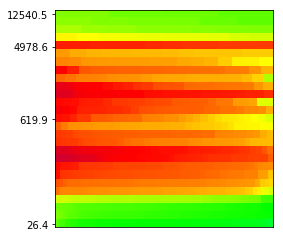

In [42]:
#graphe_temperature(S1, 0, 2000, 1000, file1, 41000, "", "AS")
graphe_temperature2(S1, 0, 2000, 1000, file1, 41000, "", "AS")

In [52]:

# Enregistre la matrice triangulaire dans un fichier
# La matrice triangulaire doit être faite ainsi :
#       - Les haute fréquences correspondent aux indices faibles
#       _ Les basse fréquences correspondent aux indices élevés
def enregistre_matrice_triangulaire(matrice_triangulaire, debut, taille, pas, fichier, sr, rout, mode):
    i = 0
    fichier_dest = fichier.split("/")
    fichier_dest = fichier_dest[len(fichier_dest) - 1]
    if mode == AS:
        val_pas = ""
    else:
        val_pas = "_pas" + strpointtotime2(pas, sr)
#    dest = rout + fichier_dest + "_sr" + str(sr) + "_deb" + str(point_to_time(debut, sr)) + "_t" + str(point_to_time(taille, sr)) + val_pas + ".txt"
    dest = rout + fichier_dest + "_sr" + str(sr) + "_deb" + strpointtotime(debut, sr) + "_t" + strpointtotime2(taille, sr) + val_pas + ".txt"
    entete = entete_matrice_triangulaire(debut, taille, pas, fichier, sr, mode)
    f = open(dest, "w")
    f.write(entete + "\n")

    print("Enregistrement du fichier : " + dest)
    while (i < len(matrice_triangulaire)):
        for j in range(0, len(matrice_triangulaire[i]), 1):
            f.write(str('{0:.6f}'.format(matrice_triangulaire[i][j])) + " ")
        f.write("\n")
        i = i + 1
    f.close()
    print("Enregistrement réussi")


# Renvoie un tableau contenant toutes les ifft concernant chaque bande
def ifft_par_bande(waveform, raies):
    fft = librosa.stft(waveform, n_fft=T_FENETRE)
    global n_freq
    n_freq = len(fft)
    nb_ifft = len(raies) - 1
    fft_prep = fft_null(fft)
    zero_init = zero_init = np.array(list_of_val((0 + 0j), len(fft[0])))
    all_ifft = []

    for i in range(0, nb_ifft, 1):
        ifft = fft_to_ifft(fft_prep, fft, zero_init, raies, len(waveform), i)
        all_ifft.append(ifft)
    return np.array(all_ifft)


# Gère une analyse simple
# Gère l'analyse complete d'un fichier
# debut : le debut de l'échantillon (en point)
# taille : la taille de l'échantillon (en point)
# fichier : le nom du fichier audio dont un échantillon va être analysé
# waveform : la forme d'onde correspondant au fichier son
# sr : fréquence d'échantillonnage du fichier
def analyse_simple(debut, taille, pas, fichier, num_echantillon, all_ifft, sr, mode, rout):
    echantillons = []
    triangle = []
    affichage_entete_as(debut, taille, fichier, num_echantillon, sr)
    nb_ifft = len(all_ifft)

    print("Calculs en cours:")
    for i in range(0, nb_ifft, 1):
        print("\t" + str(i + 1) + "/" + str(nb_ifft) + "\t---\t", end="")
        echantillons.append(np.copy(calculer_echantillon(all_ifft[i], debut, taille)))

        #pour enregistrer les fichiers wav des 27 bandes audio correction LP
        #ifft_onde(echantillons[i], sr, debut, rout, len(all_ifft) - i)  # fichiers audio
        #ifft_forme_onde(echantillons[i], sr, debut, rout, len(all_ifft) - i)  # fichiers audio old

        print("succès")
    # Echantillons est une liste d'echantillon (une matrice [][])
    echantillons = np.array(echantillons)
    triangle = creation_matrice_triangulaire(echantillons, debut, taille, pas, fichier, sr)
    enregistre_matrice_triangulaire(triangle, debut, taille, pas, fichier, sr, rout, mode)
    graphe_temperature(triangle, debut, taille, pas, fichier, sr, rout, mode)
    graphe_temperature2(triangle, debut, taille, pas, fichier, sr, rout, mode)


# Gère l'analyse complete d'un fichier
# debut : le début du premier échantillon (en ms)
# taille : la taille de chaque échantillon (en ms)
# fichier : le nom du fichier audio à analyser
# waveform : la forme d'onde correspondant au fichier son
# sr : fréquence d'échantillonage du fichier
def analyse_complete_fichier(debut, taille, pas, fichier, rout):
    try:
        i = 1
        mode = ""
        waveform, sr = librosa.load(fichier, sr=None)

        if (pas == 0):
            pas = len(waveform)
            mode = AS
        else:
            pas = time_to_point(pas, sr)
        debut = time_to_point(debut, sr)
        taille = time_to_point(taille, sr)

        if (mode != AS):
            dest = fichier.split("/")
            dest = rout + dest[len(dest) - 1].replace(".", "_") + "/"
        else:
            dest = rout

        if (not (os.path.exists(dest))):
            os.makedirs(dest)

        print("Préparation du fichier :", end=" ")
        all_ifft = ifft_par_bande(waveform, RAIES)
        print("ok")
        while (debut + taille <= len(waveform)):
            analyse_simple(debut, taille, pas, fichier, i, all_ifft, sr, mode, dest)
            debut = debut + pas
            i = i + 1
        print("Fin du fichier")
    except:
        print("Le fichier " + fichier + " n'est pas un fichier valide", file=sys.stderr)


# Gère l'analyse complète d'un répertoir
# debut : le début du premère échantillon
# taille : la taille de chaque échantillon
# pas : le pas entre chaque début d'échantillon
# rep : le répertoire comportant tous les fichiers audio à analyser
def analyse_complete_repertoire(debut, taille, pas, rep, rout):
    print("analyse complète du répertoire : " + rep)
    fichier = ""

    if (rout[len(rout) - 1] != "/"):
        rout = rout + "/"

    if (rep[len(rep) - 1] != "/"):
        rep = rep + "/"

    for contenu in os.walk(rep):
        root, dirs, files = contenu
        # Seul la première ligne du tableau nous intéresse
        break

    try:
        for file in files:
            fichier = rep + file
            analyse_complete_fichier(debut, taille, pas, fichier, rout)
        for dir in dirs:
            analyse_complete_repertoire(debut, taille, pas, rep + dir,
                                        rout + dir)
        print(rout)
    except:
        print("Erreur : répertoire d'entrée " + rep + " invalide")



In [ ]:

# Renvoie True si le mode d'analyse existe, False sinon
def mode_existe(mode):
    return ((mode == AS) or (mode == ACF) or (mode == ACR) or (mode == H))


# Renvoie une erreur si is_option vaut true
# La fonction permet de traiter le cas ou la même options apparâit plusieurs fois
def verif_option_multiple(is_option, option):
    if (is_option):
        print(
            "Erreur : il est interdit d'avoir plusieurs fois l'options " +
            option,
            end="\n\n")
        comment_aide()
        exit()
    return True


# Vérifie que 'val' est un entier
# Affiche un message d'erreur sinon et quitte
def verif_param_entier_positif(param, val):
    if (not (val.isdigit())):
        print(
            "Erreur : la valeur du paramètre " + param +
            " doit être un entier positif",
            end="\n\n")
        comment_aide()
    return int(val)


# Vérifie que la taille est valide
# Attention, le paramètre taille est une chaîne de caractère
def verif_taille_echantillon(taille):
    taille_utilisateur = verif_param_entier_positif(T, taille)
    if (taille_utilisateur < T_MIN):
        print(
            "Erreur : la taille d'un échantillon ne doit pas être inférieur à "
            + str(T_MIN))
        comment_aide()
    return taille_utilisateur


# Verifie les options qui ne sont pas communes à tous les modes d'analyse
# Erreur si non valide


def verif_option_non_universelle(mode, option):
    # Cas d'erreur du pas
    if ((mode == AS) and (option == PAS)):
        print(
            "Erreur : l'option " + PAS +
            " est disponible uniquement pour les modes " + ACF + " et " + ACR,
            end="\n\n")
        comment_aide()
    # Cas d'erreur du fichier
    if ((mode == ACR) and (option == F)):
        print(
            "Erreur : l'option " + F +
            " est disponible uniquement pour les modes " + AS + " et " + ACF,
            end="\n\n")
        comment_aide()
    # Cas d'erreur du répertoire
    if (((mode == AS) or (mode == ACF)) and (option == R)):
        print(
            "Erreur : l'option " + R +
            " est disponible uniquement pour le mode " + ACR,
            end="\n\n")
        comment_aide()



In [54]:

# Prépare les paramètres pour l'analyse qui va être effetuée

def prepare_param_analyse(mode):
    debut = DEB_DEF
    taille_echantillon = T_DEF
    pas = PAS_DEF
    fichier = ""
    rout = "."

    is_debut = False
    is_taille_echantillon = False
    is_pas = False
    is_fichier = False
    is_rout = False

    # Lit toutes les options écrites dans l'invité de commande
    # Met à jour les valeurs
    for i in range(2, len(sys.argv), 1):
        val = sys.argv[i].split("=")
        # Vérifie qu'il y a un '=' et une valeur le succédant
        if (len(val) != 2):
            print(
                "Erreur : problème dans la syntaxe de l'option " + val[0],
                end="\n\n")
            comment_aide()
        verif_option_non_universelle(mode, val[0])
        # Gestion des options inclus dans tous les modes
        if (val[0] == DEB):
            is_debut = verif_option_multiple(is_debut, DEB)
            debut = verif_param_entier_positif(DEB, val[1])
        elif (val[0] == T):
            is_taille_echantillon = verif_option_multiple(
                is_taille_echantillon, T)
            taille_echantillon = verif_taille_echantillon(val[1])
        elif (val[0] == PAS):
            is_pas = verif_option_multiple(is_pas, PAS)
            pas = verif_param_entier_positif(PAS, val[1])
        elif (val[0] == F):
            is_fichier = verif_option_multiple(is_fichier, R)
            fichier = val[1]
        elif (val[0] == R):
            is_fichier = verif_option_multiple(is_fichier, F)
            fichier = val[1]
        elif (val[0] == ROUT):
            is_rout = verif_option_multiple(is_rout, ROUT)
            rout = val[1]
        else:
            print("Erreur : l'option " + val[0] + " n'existe pas", end="\n\n")
            comment_aide()
    # S'il n'y a pas de fichier d'entrée
    if (not (is_fichier)):
        print(
            "Erreur : Il faut préciser un fichier/répertoire d'entrée",
            end="\n\n")
        comment_aide()
    return (debut, taille_echantillon, pas, fichier, rout)


# Vérifie que le mode d'analyse existe
# Erreur sinon
def verif_existe_mode():
    if (len(sys.argv) == 1):
        comment_aide()
    # Erreur si le mode n'existe pas
    if (not (mode_existe(sys.argv[1]))):
        print("Erreur : le mode " + sys.argv[1] + " n'existe pas", end="\n\n")
        comment_aide()


# Détermine le mode d'analyse selectionné
def mode_analyse():
    debut = DEB_DEF
    taille_echantillon = T_DEF
    pas = PAS_DEF
    fichier = ""
    rout = ""

    # Vérification de l'existence du mode d'analyse
    verif_existe_mode()

    # Appel de l'aide
    if (sys.argv[1] == H):
        usage()

    # Récupération des paramètres
    debut, taille_echantillon, pas, fichier, rout = prepare_param_analyse(
        sys.argv[1])

    # Ajoute un / à la fin du nom du répertoire de sortie
    if (rout[len(rout) - 1] != "/"):
        rout = rout + "/"

    # Sélection du mode d'analyse
    if (sys.argv[1] == AS):
        analyse_complete_fichier(debut, taille_echantillon, 0, fichier, rout)
    if (sys.argv[1] == ACF):
        analyse_complete_fichier(debut, taille_echantillon, pas, fichier, rout)
    if (sys.argv[1] == ACR):
        if (fichier[len(fichier) - 1] != "/"):
            fichier = fichier + "/"
        analyse_complete_repertoire(debut, taille_echantillon, pas, fichier,
                                    rout)
   

In [65]:
# Détermine le mode d'analyse selectionné
def mode_analyse_manuel(mode, debut, taille_echantillon, pas, fichier = "", rout=""):
  
    # Ajoute un / à la fin du nom du répertoire de sortie
    if (rout[len(rout) - 1] != "/"):
        rout = rout + "/"

    print("analyse simple de", fichier)
    print (mode)
  # Sélection du mode d'analyse
    if (mode == AS):
        print("analyse simpledfsd de", fichier)
        analyse_complete_fichier(debut, taille_echantillon, 0, fichier, rout)
    if (mode == ACF):
        analyse_complete_fichier(debut, taille_echantillon, pas, fichier, rout)
    if (mode == ACR):
        if (fichier[len(fichier) - 1] != "/"):
            fichier = fichier + "/"
        analyse_complete_repertoire(debut, taille_echantillon, pas, fichier,
                                    rout)
   

analyse simple de /Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/RechercheAnalyse/Corpus/05_PunkMetalNoise/VanHalen/11VanHalen.wav
acf
Préparation du fichier : ok
Fichier : laurentpottier/Documents/LP/Recherches/Projet_Fondation/RechercheAnalyse/Corpus/05_PunkMetalNoise/VanHalen/11VanHalen.wav
Taux d'échantillonnage : 44100 Hz
Echantillon : 1
début échantillon : 0 ms
taille échantillon : 2000 ms
Calculs en cours:
	1/27	---	succès
	2/27	---	succès
	3/27	---	succès
	4/27	---	succès
	5/27	---	succès
	6/27	---	succès
	7/27	---	succès
	8/27	---	succès
	9/27	---	succès
	10/27	---	succès
	11/27	---	succès
	12/27	---	succès
	13/27	---	succès
	14/27	---	succès
	15/27	---	succès
	16/27	---	succès
	17/27	---	succès
	18/27	---	succès
	19/27	---	succès
	20/27	---	succès
	21/27	---	succès
	22/27	---	succès
	23/27	---	succès
	24/27	---	succès
	25/27	---	succès
	26/27	---	succès
	27/27	---	succès
Création de la matrice triangulaire : 
OK
Enregistrement du fichier : /Users/laurentpottie

Fichier : laurentpottier/Documents/LP/Recherches/Projet_Fondation/RechercheAnalyse/Corpus/05_PunkMetalNoise/VanHalen/11VanHalen.wav
Taux d'échantillonnage : 44100 Hz
Echantillon : 9
début échantillon : 16000 ms
taille échantillon : 2000 ms
Calculs en cours:
	1/27	---	succès
	2/27	---	succès
	3/27	---	succès
	4/27	---	succès
	5/27	---	succès
	6/27	---	succès
	7/27	---	succès
	8/27	---	succès
	9/27	---	succès
	10/27	---	succès
	11/27	---	succès
	12/27	---	succès
	13/27	---	succès
	14/27	---	succès
	15/27	---	succès
	16/27	---	succès
	17/27	---	succès
	18/27	---	succès
	19/27	---	succès
	20/27	---	succès
	21/27	---	succès
	22/27	---	succès
	23/27	---	succès
	24/27	---	succès
	25/27	---	succès
	26/27	---	succès
	27/27	---	succès
Création de la matrice triangulaire : 
OK
Enregistrement du fichier : /Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/Langages&Maths/Anaconda/LPanalyse/PopPlinn/class/PopPlinnTxtSel2/11VanHalen_wav/11VanHalen.wav_sr44100_deb00_16_00_t02_00_pas02_00.t

Fichier : laurentpottier/Documents/LP/Recherches/Projet_Fondation/RechercheAnalyse/Corpus/05_PunkMetalNoise/VanHalen/11VanHalen.wav
Taux d'échantillonnage : 44100 Hz
Echantillon : 17
début échantillon : 32000 ms
taille échantillon : 2000 ms
Calculs en cours:
	1/27	---	succès
	2/27	---	succès
	3/27	---	succès
	4/27	---	succès
	5/27	---	succès
	6/27	---	succès
	7/27	---	succès
	8/27	---	succès
	9/27	---	succès
	10/27	---	succès
	11/27	---	succès
	12/27	---	succès
	13/27	---	succès
	14/27	---	succès
	15/27	---	succès
	16/27	---	succès
	17/27	---	succès
	18/27	---	succès
	19/27	---	succès
	20/27	---	succès
	21/27	---	succès
	22/27	---	succès
	23/27	---	succès
	24/27	---	succès
	25/27	---	succès
	26/27	---	succès
	27/27	---	succès
Création de la matrice triangulaire : 
OK
Enregistrement du fichier : /Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/Langages&Maths/Anaconda/LPanalyse/PopPlinn/class/PopPlinnTxtSel2/11VanHalen_wav/11VanHalen.wav_sr44100_deb00_32_00_t02_00_pas02_00.

Fichier : laurentpottier/Documents/LP/Recherches/Projet_Fondation/RechercheAnalyse/Corpus/05_PunkMetalNoise/VanHalen/11VanHalen.wav
Taux d'échantillonnage : 44100 Hz
Echantillon : 25
début échantillon : 48000 ms
taille échantillon : 2000 ms
Calculs en cours:
	1/27	---	succès
	2/27	---	succès
	3/27	---	succès
	4/27	---	succès
	5/27	---	succès
	6/27	---	succès
	7/27	---	succès
	8/27	---	succès
	9/27	---	succès
	10/27	---	succès
	11/27	---	succès
	12/27	---	succès
	13/27	---	succès
	14/27	---	succès
	15/27	---	succès
	16/27	---	succès
	17/27	---	succès
	18/27	---	succès
	19/27	---	succès
	20/27	---	succès
	21/27	---	succès
	22/27	---	succès
	23/27	---	succès
	24/27	---	succès
	25/27	---	succès
	26/27	---	succès
	27/27	---	succès
Création de la matrice triangulaire : 
OK
Enregistrement du fichier : /Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/Langages&Maths/Anaconda/LPanalyse/PopPlinn/class/PopPlinnTxtSel2/11VanHalen_wav/11VanHalen.wav_sr44100_deb00_48_00_t02_00_pas02_00.

Fichier : laurentpottier/Documents/LP/Recherches/Projet_Fondation/RechercheAnalyse/Corpus/05_PunkMetalNoise/VanHalen/11VanHalen.wav
Taux d'échantillonnage : 44100 Hz
Echantillon : 33
début échantillon : 64000 ms
taille échantillon : 2000 ms
Calculs en cours:
	1/27	---	succès
	2/27	---	succès
	3/27	---	succès
	4/27	---	succès
	5/27	---	succès
	6/27	---	succès
	7/27	---	succès
	8/27	---	succès
	9/27	---	succès
	10/27	---	succès
	11/27	---	succès
	12/27	---	succès
	13/27	---	succès
	14/27	---	succès
	15/27	---	succès
	16/27	---	succès
	17/27	---	succès
	18/27	---	succès
	19/27	---	succès
	20/27	---	succès
	21/27	---	succès
	22/27	---	succès
	23/27	---	succès
	24/27	---	succès
	25/27	---	succès
	26/27	---	succès
	27/27	---	succès
Création de la matrice triangulaire : 
OK
Enregistrement du fichier : /Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/Langages&Maths/Anaconda/LPanalyse/PopPlinn/class/PopPlinnTxtSel2/11VanHalen_wav/11VanHalen.wav_sr44100_deb01_04_00_t02_00_pas02_00.

Fichier : laurentpottier/Documents/LP/Recherches/Projet_Fondation/RechercheAnalyse/Corpus/05_PunkMetalNoise/VanHalen/11VanHalen.wav
Taux d'échantillonnage : 44100 Hz
Echantillon : 41
début échantillon : 80000 ms
taille échantillon : 2000 ms
Calculs en cours:
	1/27	---	succès
	2/27	---	succès
	3/27	---	succès
	4/27	---	succès
	5/27	---	succès
	6/27	---	succès
	7/27	---	succès
	8/27	---	succès
	9/27	---	succès
	10/27	---	succès
	11/27	---	succès
	12/27	---	succès
	13/27	---	succès
	14/27	---	succès
	15/27	---	succès
	16/27	---	succès
	17/27	---	succès
	18/27	---	succès
	19/27	---	succès
	20/27	---	succès
	21/27	---	succès
	22/27	---	succès
	23/27	---	succès
	24/27	---	succès
	25/27	---	succès
	26/27	---	succès
	27/27	---	succès
Création de la matrice triangulaire : 
OK
Enregistrement du fichier : /Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/Langages&Maths/Anaconda/LPanalyse/PopPlinn/class/PopPlinnTxtSel2/11VanHalen_wav/11VanHalen.wav_sr44100_deb01_20_00_t02_00_pas02_00.

Fichier : laurentpottier/Documents/LP/Recherches/Projet_Fondation/RechercheAnalyse/Corpus/05_PunkMetalNoise/VanHalen/11VanHalen.wav
Taux d'échantillonnage : 44100 Hz
Echantillon : 49
début échantillon : 96000 ms
taille échantillon : 2000 ms
Calculs en cours:
	1/27	---	succès
	2/27	---	succès
	3/27	---	succès
	4/27	---	succès
	5/27	---	succès
	6/27	---	succès
	7/27	---	succès
	8/27	---	succès
	9/27	---	succès
	10/27	---	succès
	11/27	---	succès
	12/27	---	succès
	13/27	---	succès
	14/27	---	succès
	15/27	---	succès
	16/27	---	succès
	17/27	---	succès
	18/27	---	succès
	19/27	---	succès
	20/27	---	succès
	21/27	---	succès
	22/27	---	succès
	23/27	---	succès
	24/27	---	succès
	25/27	---	succès
	26/27	---	succès
	27/27	---	succès
Création de la matrice triangulaire : 
OK
Enregistrement du fichier : /Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/Langages&Maths/Anaconda/LPanalyse/PopPlinn/class/PopPlinnTxtSel2/11VanHalen_wav/11VanHalen.wav_sr44100_deb01_36_00_t02_00_pas02_00.

Fichier : laurentpottier/Documents/LP/Recherches/Projet_Fondation/RechercheAnalyse/Corpus/05_PunkMetalNoise/VanHalen/11VanHalen.wav
Taux d'échantillonnage : 44100 Hz
Echantillon : 57
début échantillon : 112000 ms
taille échantillon : 2000 ms
Calculs en cours:
	1/27	---	succès
	2/27	---	succès
	3/27	---	succès
	4/27	---	succès
	5/27	---	succès
	6/27	---	succès
	7/27	---	succès
	8/27	---	succès
	9/27	---	succès
	10/27	---	succès
	11/27	---	succès
	12/27	---	succès
	13/27	---	succès
	14/27	---	succès
	15/27	---	succès
	16/27	---	succès
	17/27	---	succès
	18/27	---	succès
	19/27	---	succès
	20/27	---	succès
	21/27	---	succès
	22/27	---	succès
	23/27	---	succès
	24/27	---	succès
	25/27	---	succès
	26/27	---	succès
	27/27	---	succès
Création de la matrice triangulaire : 
OK
Enregistrement du fichier : /Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/Langages&Maths/Anaconda/LPanalyse/PopPlinn/class/PopPlinnTxtSel2/11VanHalen_wav/11VanHalen.wav_sr44100_deb01_52_00_t02_00_pas02_00

Fichier : laurentpottier/Documents/LP/Recherches/Projet_Fondation/RechercheAnalyse/Corpus/05_PunkMetalNoise/VanHalen/11VanHalen.wav
Taux d'échantillonnage : 44100 Hz
Echantillon : 65
début échantillon : 128000 ms
taille échantillon : 2000 ms
Calculs en cours:
	1/27	---	succès
	2/27	---	succès
	3/27	---	succès
	4/27	---	succès
	5/27	---	succès
	6/27	---	succès
	7/27	---	succès
	8/27	---	succès
	9/27	---	succès
	10/27	---	succès
	11/27	---	succès
	12/27	---	succès
	13/27	---	succès
	14/27	---	succès
	15/27	---	succès
	16/27	---	succès
	17/27	---	succès
	18/27	---	succès
	19/27	---	succès
	20/27	---	succès
	21/27	---	succès
	22/27	---	succès
	23/27	---	succès
	24/27	---	succès
	25/27	---	succès
	26/27	---	succès
	27/27	---	succès
Création de la matrice triangulaire : 
OK
Enregistrement du fichier : /Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/Langages&Maths/Anaconda/LPanalyse/PopPlinn/class/PopPlinnTxtSel2/11VanHalen_wav/11VanHalen.wav_sr44100_deb02_08_00_t02_00_pas02_00

Fichier : laurentpottier/Documents/LP/Recherches/Projet_Fondation/RechercheAnalyse/Corpus/05_PunkMetalNoise/VanHalen/11VanHalen.wav
Taux d'échantillonnage : 44100 Hz
Echantillon : 73
début échantillon : 144000 ms
taille échantillon : 2000 ms
Calculs en cours:
	1/27	---	succès
	2/27	---	succès
	3/27	---	succès
	4/27	---	succès
	5/27	---	succès
	6/27	---	succès
	7/27	---	succès
	8/27	---	succès
	9/27	---	succès
	10/27	---	succès
	11/27	---	succès
	12/27	---	succès
	13/27	---	succès
	14/27	---	succès
	15/27	---	succès
	16/27	---	succès
	17/27	---	succès
	18/27	---	succès
	19/27	---	succès
	20/27	---	succès
	21/27	---	succès
	22/27	---	succès
	23/27	---	succès
	24/27	---	succès
	25/27	---	succès
	26/27	---	succès
	27/27	---	succès
Création de la matrice triangulaire : 
OK
Enregistrement du fichier : /Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/Langages&Maths/Anaconda/LPanalyse/PopPlinn/class/PopPlinnTxtSel2/11VanHalen_wav/11VanHalen.wav_sr44100_deb02_24_00_t02_00_pas02_00

Fichier : laurentpottier/Documents/LP/Recherches/Projet_Fondation/RechercheAnalyse/Corpus/05_PunkMetalNoise/VanHalen/11VanHalen.wav
Taux d'échantillonnage : 44100 Hz
Echantillon : 81
début échantillon : 160000 ms
taille échantillon : 2000 ms
Calculs en cours:
	1/27	---	succès
	2/27	---	succès
	3/27	---	succès
	4/27	---	succès
	5/27	---	succès
	6/27	---	succès
	7/27	---	succès
	8/27	---	succès
	9/27	---	succès
	10/27	---	succès
	11/27	---	succès
	12/27	---	succès
	13/27	---	succès
	14/27	---	succès
	15/27	---	succès
	16/27	---	succès
	17/27	---	succès
	18/27	---	succès
	19/27	---	succès
	20/27	---	succès
	21/27	---	succès
	22/27	---	succès
	23/27	---	succès
	24/27	---	succès
	25/27	---	succès
	26/27	---	succès
	27/27	---	succès
Création de la matrice triangulaire : 
OK
Enregistrement du fichier : /Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/Langages&Maths/Anaconda/LPanalyse/PopPlinn/class/PopPlinnTxtSel2/11VanHalen_wav/11VanHalen.wav_sr44100_deb02_40_00_t02_00_pas02_00

Fichier : laurentpottier/Documents/LP/Recherches/Projet_Fondation/RechercheAnalyse/Corpus/05_PunkMetalNoise/VanHalen/11VanHalen.wav
Taux d'échantillonnage : 44100 Hz
Echantillon : 89
début échantillon : 176000 ms
taille échantillon : 2000 ms
Calculs en cours:
	1/27	---	succès
	2/27	---	succès
	3/27	---	succès
	4/27	---	succès
	5/27	---	succès
	6/27	---	succès
	7/27	---	succès
	8/27	---	succès
	9/27	---	succès
	10/27	---	succès
	11/27	---	succès
	12/27	---	succès
	13/27	---	succès
	14/27	---	succès
	15/27	---	succès
	16/27	---	succès
	17/27	---	succès
	18/27	---	succès
	19/27	---	succès
	20/27	---	succès
	21/27	---	succès
	22/27	---	succès
	23/27	---	succès
	24/27	---	succès
	25/27	---	succès
	26/27	---	succès
	27/27	---	succès
Création de la matrice triangulaire : 
OK
Enregistrement du fichier : /Users/laurentpottier/Documents/LP/Recherches/Projet_Fondation/Langages&Maths/Anaconda/LPanalyse/PopPlinn/class/PopPlinnTxtSel2/11VanHalen_wav/11VanHalen.wav_sr44100_deb02_56_00_t02_00_pas02_00

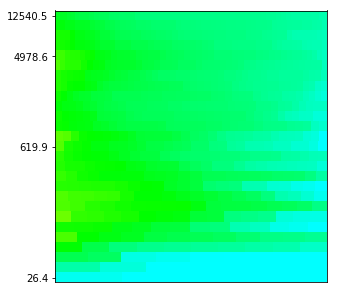

In [115]:
# in snd_folder_path

def findfile(txt, liste):
    # donne la liste des index pour lesquels on trouve txt dans liste
    res = []
    for i in range (len(liste)):
        if (liste[i].find(txt)>=0):
            res.append(i)
    return res
        
#lindex =  findfile("VanHale", sndlist)
#print(sndpathlist[lindex[0]]+"/"+sndlist[lindex[0]])

def findNthSndfile (n, txt, liste):
    res = findfile(txt, liste)
    if (res != []):
        return sndpathlist[res[0]]+"/"+sndlist[res[0]]
    
#print(findNthSndfile(0, "VanHale", sndlist))

#mode_analyse_manuel(AS, 0, 2000, 2000, findNthSndfile(0, "VanHale", sndlist), folder_path)
mode_analyse_manuel(ACF, 0, 2000, 2000, findNthSndfile(0, "VanHale", sndlist), folder_path)